# Samplers in bgflow

Each object that can produce samples from some distribution is implemented as a subclass of `Sampler`. There are four ways to create samples:

- Sampling from probability distributions
- Sampling from data
- Sampling from energy functions via iterative samplers
- Sampling from deep generative models

## Sampling from Probability Distributions

In [1]:
import torch
from bgflow import NormalDistribution

normal = NormalDistribution(dim=3, mean=torch.ones(3))
normal.sample(1000).shape
normal.sample(1000).mean()

tensor(1.0260)

We can also use all distributions implemented in `torch.distributions` through the wrapper class `TorchDistribution`.

In [2]:
%pdb off
from torch.distributions import Weibull, Independent
from bgflow import TorchDistribution

base = Weibull(scale=torch.ones(3), concentration=torch.ones(3))
weibull = TorchDistribution(Independent(base, 1))
weibull.sample(10).shape

Automatic pdb calling has been turned OFF


torch.Size([10, 3])

Through the `Independent` class, the last dimension is considered as an event dimension and summed over.

The formalism of event dimensions is adopted from `torch.distributions.`
Therein, the shape of a tensor of samples is decomposed in `(*sample_shape, *batch_shape, *event_shape).`

For example, let's consider a system of `n` 3-dimensional particles. We have a minibatch of `b` such systems, where each element in the batch is associated with a different temperature. Now we create `s` samples and compute their energies.

The samples in this example have shape `(s, b, n, 3)`.
- We have two "event dimensions", i.e. the event shape is `(n,3)`.
- We have one "batch dimension", i.e. the batch shape is `(b,)`.
- We have one "sample dimension", i.e. the sample shape is `(s,)`


In addition, distributions and energies in `bgflow` can be defined on multiple events. For example, consider the prior energy to an IC flow, which can be defined on the product distribution of bond, angle, and torsion events. When sampling from such a prior, we want to return multiple tensors. The sampler framework supports these multiple-event distributions through `ProductDistribution` and `ProductSampler`. 

For example:

In [3]:
from bgflow import ProductDistribution
product = ProductDistribution([weibull, normal])
print(product.event_shapes)

w, n = product.sample(10)
print(w.shape, n.shape)

product.energy(w, n)

[torch.Size([3]), torch.Size([3])]
torch.Size([10, 3]) torch.Size([10, 3])


tensor([[10.3844],
        [ 6.5218],
        [10.6510],
        [ 4.4975],
        [ 5.6405],
        [ 4.4356],
        [ 6.4569],
        [ 5.6919],
        [ 4.7252],
        [ 7.0971]])

## Sampling from Data

For illustration, let us use a dataset from `bgmol`.

In [4]:
from bgmol.datasets import Ala2TSF1000
from bgflow import DataSetSampler

In [5]:
data = Ala2TSF1000(read=True, download=True)

Using downloaded and verified file: /srv/public/kraemea88/coding/bgflow/notebooks/Ala2TSF1000.tgz
Extracting /srv/public/kraemea88/coding/bgflow/notebooks/Ala2TSF1000.tgz to /srv/public/kraemea88/coding/bgflow/notebooks
Using downloaded and verified file: /tmp/alanine-dipeptide-nowater.pdb


We can set up a data sampler to sample from this set.

In [6]:
datasampler = DataSetSampler(torch.tensor(data.coordinates), shuffle=True)
datasampler.sample(100).shape

torch.Size([100, 22, 3])

It works for arbitrary numbers of tensors. Furthermore, samples can be automatically pushed to a chosen dtype and device. 

In [7]:
datasampler = DataSetSampler(
    torch.tensor(data.coordinates),
    torch.arange(len(data.coordinates)),
    dtype=torch.float64,
    device="cuda:0",
    shuffle=True
)
x, y = datasampler.sample(10)
x.shape, x.device, y.shape, y.device

(torch.Size([10, 22, 3]),
 device(type='cuda', index=0),
 torch.Size([10]),
 device(type='cuda', index=0))

We can also sample from `DataLoader`s:

In [8]:
dataloader = torch.utils.data.DataLoader(data.coordinates, batch_size=128)

In [9]:
from bgflow import DataLoaderSampler
loadersampler = DataLoaderSampler(
    dataloader, dtype=torch.float32, device=torch.device("cpu")
)

In [10]:
loadersampler.sample(128).shape

torch.Size([128, 22, 3])

The DataLoaderSampler, however, can only sample with the same batch size:

In [11]:
try:
    loadersampler.sample(130).shape
except:
    print("Not possible.")

Not possible.


## Sampling from Energies

To sample from energies, we need either a generative model (a flow), or an iterative sampler. Let's have a look into the `IterativeSampler` framework. 

### MCMC Sampling
We'll first use Gaussian MCMC to sample from a 2D LJ system at different temperatures.

In [12]:
from bgflow import IterativeSampler, SamplerStep, MCMCStep, SamplerState, GaussianProposal
from bgflow import DoubleWellEnergy
import tqdm

In [13]:
target_energy = DoubleWellEnergy(dim=2)
mcmc_step = MCMCStep(
    target_energy,
    proposal=GaussianProposal(noise_std=0.1),
    target_temperatures=torch.tensor([1., 10.])
)

We'll use a few additional add-ones:
- a progress bar 
- a hook, that only returns the lowest-temperature sample

In [14]:
mcsampler = IterativeSampler(
    SamplerState(torch.randn(2,2)),
    [mcmc_step],
    stride=100,
    progress_bar=tqdm.auto.tqdm,
    return_hook=lambda samples: [samples[0][:,0]]
)

0it [00:00, ?it/s]

In [15]:
samples = mcsampler.sample_to_cpu(128, batch_size=64)

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

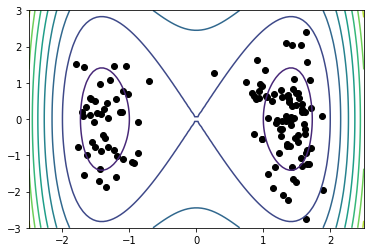

In [16]:
from matplotlib import pyplot as plt
from bgflow.utils.types import as_numpy

x = torch.linspace(-2.5,2.5,100)
y = torch.linspace(-3,3,100)
X, Y = torch.meshgrid(x,y)
Z = target_energy.energy(torch.stack([X,Y], dim=-1).reshape(-1,2))
plt.contour(as_numpy(X),as_numpy(Y), as_numpy(Z).reshape(100,100))

plt.scatter(samples[:,0], samples[:,1], c="black")

### Custom Sampling

The iterative sampler is written in a modular way and it is quite easy to implement additional steps or customize its behavior through hooks. For example, here's the implementation of a verlet integrator.

In [17]:
from bgflow.utils.types import pack_tensor_in_list

class VelocityVerletStep(SamplerStep):
    """VelocityVerlet integrator for a target energy with a single event shape."""
    def __init__(self, target_energy, masses, dt=1., n_steps=1):
        super().__init__(n_steps)
        self.target_energy = target_energy
        self.masses = pack_tensor_in_list(masses)
        self.dt = dt
        
    def _step(self, state):
        if state.needs_update(check_forces=True, check_energies=False):
            state.forces = self.target_energy.force(*state.samples)
            
        # position update
        state.samples = [
            x + self.dt * v + 0.5 * f / m * self.dt**2
            for x, v, m in zip(state.samples, state.velocities, self.masses)
        ]
        # 1st velocity update
        state.velocities = [
            v + 0.5 * self.dt * f / m
            for v, f, m in zip(state.velocities, state.forces, self.masses)
        ]

        # compute energies and forces
        state.energies = self.target_energy.energy(*state.samples)
        state.forces = self.target_energy.force(*state.samples)
        # 2nd velocity update
        state.velocities = [
            v + 0.5 * self.dt * f / m
            for v, f, m in zip(state.velocities, state.forces, self.masses)
        ]
        
        return state


Let's initialize the sampler state with the fields that are required for the integration.

In [18]:
x = torch.randn(2,2)
v = torch.randn(2,2)
e = target_energy.energy(x)
f = target_energy.force(x)
state = SamplerState(
    samples=x, velocities=v, energies=e, forces=f
)

Each sampler iteration runs 5 steps of MD with the Verlet integrator and then performs one Monte-Carlo step.

In [19]:
%pdb
vstep = VelocityVerletStep(target_energy, masses=torch.ones(2), dt=0.001, n_steps=5)

vmcsampler = IterativeSampler(
    state,
    [vstep, mcmc_step],
    stride=1,
    progress_bar=tqdm.auto.tqdm
)

samples = vmcsampler.sample_to_cpu(512, batch_size=512)

Automatic pdb calling has been turned ON


0it [00:00, ?it/s]

  0%|          | 0/512 [00:00<?, ?it/s]

### Plot Trajectories

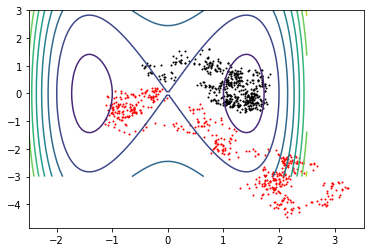

In [20]:
from matplotlib import pyplot as plt
from bgflow.utils.types import as_numpy

x = torch.linspace(-2.5,2.5,100)
y = torch.linspace(-3.,3.,100)
X, Y = torch.meshgrid(x,y)
Z = target_energy.energy(torch.stack([X,Y], dim=-1).reshape(-1,2))
plt.contour(as_numpy(X),as_numpy(Y), as_numpy(Z).reshape(100,100))

samples = as_numpy(samples)
plt.scatter(samples[:,0,0], samples[:,0,1], c="black", s=1.0)
plt.scatter(samples[:,1,0], samples[:,1,1], c="red", s=1.0)

## Detour: Sampling from a Replay Buffer

A replay buffer is a dataset sampler that can be updated with new samples.

In [21]:
from bgflow import MetropolizedReplayBuffer
from torch.distributions import Normal

proposal_distribution = NormalDistribution(2)
buffersampler = MetropolizedReplayBuffer(
    torch.tensor(samples[:,0]),
    target_energy=target_energy,
    proposal_energy=proposal_distribution
)
buffersampler.sample(10).shape

torch.Size([10, 2])

In [22]:
for i in range(10):
    proposed = proposal_distribution.sample(10)
    n_accepted = buffersampler.update(proposed)
    print(n_accepted)

4
5
1
4
2
4
8
1
5
3


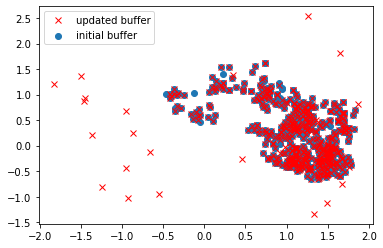

In [23]:
plt.scatter(samples[:,0,0], samples[:,0,1], label="initial buffer")
plt.plot(buffersampler.data[0][:,0], buffersampler.data[0][:,1], "x", color="red", label="updated buffer")
plt.legend()